# Dogs Breed Classification 

In this Research we will try to build a Convolutional neural network that recognizes a dog's breed among other 120 that we'll learn.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input , Dense, Flatten, Dropout, Conv2D, MaxPool2D

from tensorflow.keras.applications import resnet_v2, inception_resnet_v2

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy

## Download and preprocess the data

We'll use the Tensorflow API to download and preprocess the dataset.

In [46]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

One quick check of what we got.

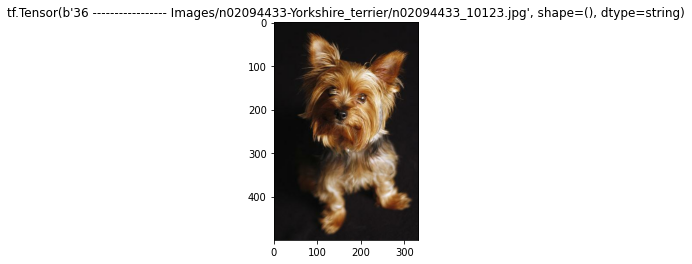

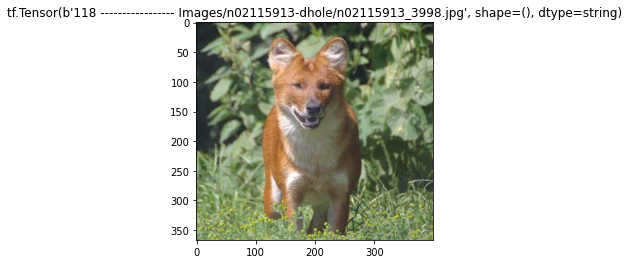

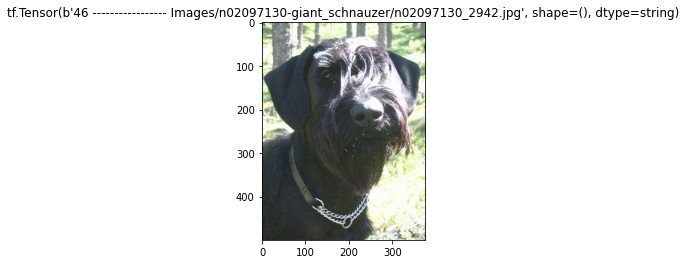

In [47]:
for x in dataset['train'].take(3):
  plt.imshow(x['image'])
  plt.title(str(x['label'].numpy()) + " ----------------- "+  x['image/filename'])
  plt.show()

## Prepare Transfer Learning and Image processing.

In [48]:
resnet_inception = inception_resnet_v2.InceptionResNetV2()

In [49]:
len(resnet_inception.layers)

782

In [50]:
IMG_LEN = 299
IMG_SHAPE = (IMG_LEN, IMG_LEN,3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):
  
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
    label = tf.one_hot(ds_row['label'],N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

Resnet Inception as you saw is a huge model and we will need to change only the last layer. We are going to make it work for our dataset. We will remain with the pre-trained weights of the convolutional layers from Image-net because the Stanford Dogs Dataset is created by the same source anyway, so it should be good.

In [51]:
resnet_inception = Model(inputs = resnet_inception.layers[0].input, outputs = resnet_inception.layers[780].output)

In [52]:
for layer in resnet_inception.layers:
  layer.trainable = False

By adding augmentation layer we flip, rotate and zoom the pictures. Not only do we create more data, we also make the model learn harder different positions and features.

In [53]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(299, 
                                                              299,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Training

The tuning process has been performed in different folder. Here we will train our model with its final hyperparameters.

In [54]:
resnet_inception = Sequential([
                           data_augmentation,
                           resnet_inception,
                           Dense(N_BREEDS, activation = 'softmax')
])

We add only one Dense Layer with 120 units to classify for our dataset. The ResnetInception convolutional layers are the huge part of it and we don't need to overkill the process with even more fully conected layers. It's not necessary.

In [55]:
resnet_inception.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy', TopKCategoricalAccuracy(k=3)])

The Adam optimizer works well, the Learning rate is significantly lower than the default one but here we'll only have one final model so we should give it all and for loss we use the categorical cross entropy which is a standard for classification with more labels and the metrics we care about are accuracy and TopKCategoricalAccuracy. The final one is a bit more interesting so let's explain it.

The dataset is hard even for humans. Some of the breeds are very much alike. This is why having this metrics as high as possible is important. We might not be able to tell the difference between Belgian Malinois and German Shepherd but we must for sure conclude it's one of them.

In [56]:
train_batches = prepare(training_data, batch_size=128)
test_batches = prepare(test_data, batch_size=128)

Prepare the dataset. Let's also have Early stopping based on Validation loss. If it doesn't improve/decline for three straight epochs, we will stop the process.

In [57]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [58]:
history_resnet_inception = resnet_inception.fit(train_batches, validation_data=test_batches,  epochs = 30, callbacks = [early_stopping])

Epoch 1/30
94/94 [==============================] - 129s 1s/step - loss: 4.8780 - accuracy: 0.0061 - top_k_categorical_accuracy: 0.0167 - val_loss: 4.7707 - val_accuracy: 0.0098 - val_top_k_categorical_accuracy: 0.0269
Epoch 2/30
94/94 [==============================] - 116s 1s/step - loss: 4.7491 - accuracy: 0.0102 - top_k_categorical_accuracy: 0.0387 - val_loss: 4.6442 - val_accuracy: 0.0244 - val_top_k_categorical_accuracy: 0.0618
Epoch 3/30
94/94 [==============================] - 115s 1s/step - loss: 4.6226 - accuracy: 0.0325 - top_k_categorical_accuracy: 0.0789 - val_loss: 4.5209 - val_accuracy: 0.0556 - val_top_k_categorical_accuracy: 0.1199
Epoch 4/30
94/94 [==============================] - 115s 1s/step - loss: 4.5060 - accuracy: 0.0612 - top_k_categorical_accuracy: 0.1351 - val_loss: 4.4000 - val_accuracy: 0.0914 - val_top_k_categorical_accuracy: 0.2064
Epoch 5/30
94/94 [==============================] - 115s 1s/step - loss: 4.3865 - accuracy: 0.1040 - top_k_categorical_accur

## Examine the results

We could have used Tensorboard but for the purposes of this report we will do the EDA ourselves here on place. A simple plotting function will do just fine.

In [59]:
def plot_train_and_validation_results(train, validation, title):
  plt.plot(train)
  plt.plot(validation)
  plt.title(title)
  plt.legend(['Training', 'Validation'])
  plt.show()

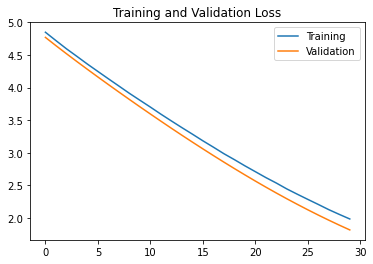

In [60]:
plot_train_and_validation_results(history_resnet_inception.history['loss'], history_resnet_inception.history['val_loss'], 'Training and Validation Loss' )

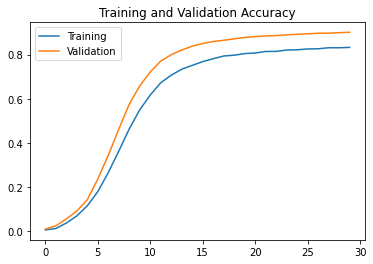

In [61]:
plot_train_and_validation_results(history_resnet_inception.history['accuracy'], history_resnet_inception.history['val_accuracy'], 'Training and Validation Accuracy' )

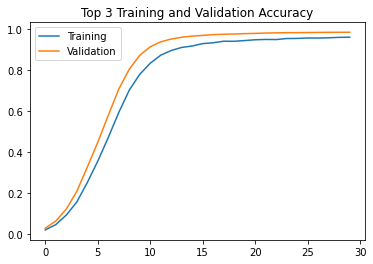

In [62]:
plot_train_and_validation_results(history_resnet_inception.history['top_k_categorical_accuracy'], history_resnet_inception.history['val_top_k_categorical_accuracy'], 'Top 3 Training and Validation Accuracy' )

### Problems
First things first. Surprisingly or not we've got better performance on validation data. We need to adress that. Is it overfitting, leak, bad distribution or simply easier observations? 

First of all the margin is insignificant and the gap is constantly shrinking. Second, the distribution is fine. Yes, the dataset is not perfectly balanced but its close to that state. Third, the data augmentation and different regularization techniques are not applied to the validation set. Last but not least, the learning graphics look perfectly fine.

### Scores
Let's analyze the results now. Based on both Training and Validation data we should expect between 82%(training) and 90%(validation) accuracy with one guess. The metrics Val Top K Accuracy that we set up to look for the top 3 classes is even greater with between 95-98% score. In other words there is around 91% chance our model to recognize the label instantly and around 98% to put the correct label in a sample of 2 other labels.


### Learning Graphics

Based on the last graphics we could have stopped the model earlier. The Accuracy and  Top K Accuracy didn't improve much from epoch 15 to epoch 50. But they were going up slowly still.  And most importantly the Loss curve looks great. Even though the other two kind of stagnated, the loss learning curve kept getting deeper. Based on the tuning process and the final few epochs it slowed down a bit but the model was still learning and the stagnation of the other two metrics is result of the very hard and relatively small dataset. 

Conclusion - the model was learning and it will continue to learn for at least  few more epochs if we decide to continue or even add more data.

## Test it with URLs from Internet

In [63]:
from skimage.io import imread
from skimage.transform import resize

In [82]:
image = imread('https://epi.azureedge.net/website-images/images/default-album/yorkshire-terrierdf23b6a24c9f653bbdf5ff0000035de2.jpg?sfvrsn=64bcd37b_2')

Let's try it with one of the most difficult classes as described in the data source. This buddy on the picture is a Yorkshire terrier.

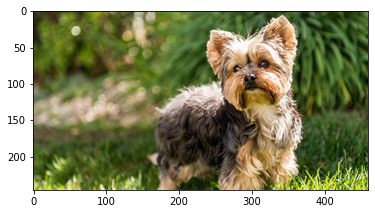

In [65]:
plt.imshow(image)
plt.show()

We are going to test with several pictures so let's make a function so we don't repeat code unnecessarily.

In [116]:
def name_the_breed(raw_picture, model, named_labels):
  picture = resize(raw_picture, (299, 299), preserve_range = True)
  picture = tf.keras.applications.inception_resnet_v2.preprocess_input(picture)
  picture = tf.expand_dims(picture, axis = 0)
  predictions = model.predict(picture)
  # decode_predictions = tf.keras.applications.inception_resnet_v2.decode_predictions(predictions, top=3)
  prediction = max(predictions[0])
  index = list(predictions[0]).index(prediction)
  score = f'This is a {named_labels[index]} with {round((100 * prediction), 2)} % certainty'
  return  score


In [70]:
import pickle

In [124]:
# This is a dictionary that I created in order to get names not raw numbers.

dictionary = open('drive/MyDrive/dict_of_labels.pickle', 'rb')
named_labels = pickle.load(dictionary)
dictionary.close()

In [117]:
print(name_the_breed(image, resnet_inception, named_labels=named_labels))

This is a Yorkshire_terrier with 21.3 % certainty


We are gonna test it with German Shepherd now.

In [118]:
image2 = imread('https://kc-media-cdn-live.azureedge.net/cache/a/3/b/3/8/2/a3b382340f57e8d45582a14a9dffc701cf061f7e.jpg')

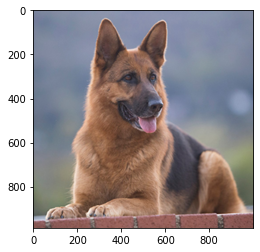

In [120]:
plt.imshow(image2)
plt.show()

In [119]:
print(name_the_breed(image2, resnet_inception, named_labels=named_labels))

This is a German_shepherd with 14.48 % certainty


Another one that pops in my mind is Tibetan Mastif. Let's try it.

In [121]:
image3 = imread('https://images.saymedia-content.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTc2MjkyMzMzODU1MTg4MTU4/tibetan-mastiffs-ancestors-of-10-new-dog-breeds.jpg')

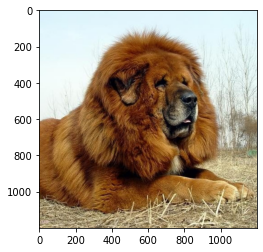

In [122]:
plt.imshow(image3)
plt.show()

In [123]:
print(name_the_breed(image3, resnet_inception, named_labels=named_labels))

This is a Tibetan_mastiff with 26.27 % certainty


In [125]:
image4 = imread('https://www.purelypetsinsurance.co.uk/media/1284/poodle-1.jpg')

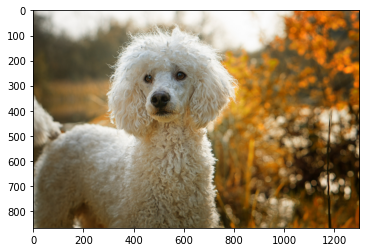

In [126]:
plt.imshow(image4)
plt.show()

In [127]:
print(name_the_breed(image4, resnet_inception, named_labels=named_labels))

This is a standard_poodle with 12.73 % certainty


As we can see the model guessed correctly all the four pictures we gave it to it. But it's not very certain. We interrupted the model while the loss was still going down so we can freely and easily go for few more rounds of training. 